In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

## 1. Read raw datacube and remove background & fringe

In [2]:
raw_datacube = Read_Raw_SITELLE_datacube("/home/qliu/data/A2390F/A2390NWC4.fits",name="A2390W")
raw_datacube.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                 2048 / Axis length                                    
NAXIS2  =                 2064 / Axis length                                    
NAXIS3  =                  150 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2017-11-09T22:04:20' / Time of last modification                     
PROGRAM = 'ORB v3.1.2'         / Thomas Martin: thomas.martin.1@ulaval.ca       
DATE    = '2017-11-09T22:05:11' / Creation date                                 
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectr

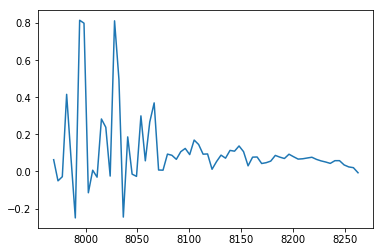

In [5]:
# med_stack = np.median(raw_datacube.raw_cube, axis=0)
spec_med = [np.median(raw_datacube.raw_cube[k]) for k in range(len(raw_datacube.wavl))]
plt.plot(raw_datacube.wavl, spec_med)

In [3]:
raw_datacube.save_mask_edge(save_path = './proc/A2390W/')

Remove 2D background channel by channel.

In [8]:
raw_datacube.remove_background(box_size=128, save_path='./A2390NW/fig_iso/bkg/128/', plot=False)

Removing background... Channel: 10


KeyboardInterrupt: 

Check stack field. Note the strong fringe pattern.

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(raw_datacube.stack_field, norm=norm1, origin="lower", vmin=0, vmax=3)

Looking at some specific channels which suffer most. One choice is to not use / interpolate by nearby channels.

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(18,6))
for i, ax in zip([3,5,6], axes):
    ax.imshow(raw_datacube.datacube_bkg_sub[i], norm=norm1, origin="lower", vmin=0, vmax=1)

Interpolate from adjacent channels to reduce fringe effects in later on detection.

In [36]:
raw_datacube.interp_bad_channel(wavl_intp_range=[7980,8000])

Interpolate bad channels: 4, 5, 6, 7, 8


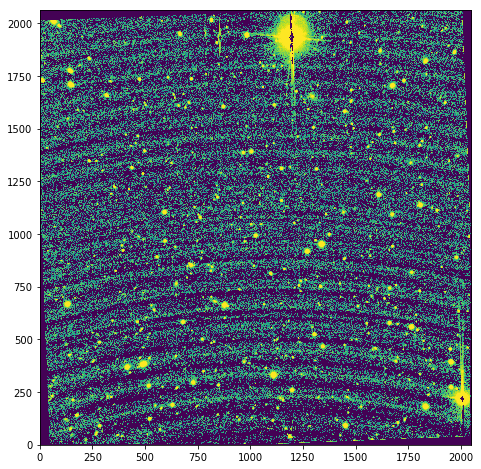

In [37]:
plt.figure(figsize=(8,8))
plt.imshow(raw_datacube.stack_field, norm=norm1, origin="lower", vmin=0, vmax=3)

Looking at one spaxel before and after interpolation:

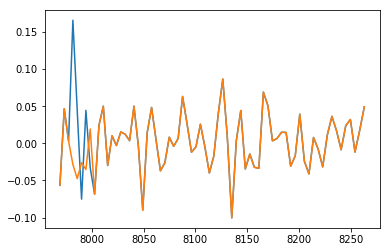

In [38]:
plt.plot(raw_datacube.wavl, raw_datacube.datacube_bkg_sub[:, 1000,800])
plt.plot(raw_datacube.wavl, raw_datacube.cube_process[:, 1000,800])

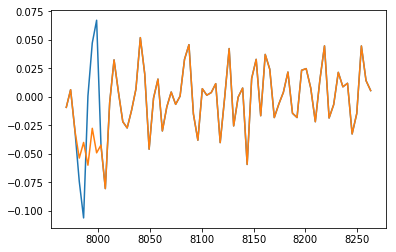

In [44]:
plt.plot(raw_datacube.wavl, raw_datacube.datacube_bkg_sub[:, 1200,25])
plt.plot(raw_datacube.wavl, raw_datacube.cube_process[:, 1200,25])

In [45]:
raw_datacube.remove_fringe(channels=np.arange(raw_datacube.shape[0]), save_path='./A2390NW/fig_iso/bkg/128/', plot=False)

Removing fringe... Channel: 0
Removing fringe... Channel: 1
Removing fringe... Channel: 2
Removing fringe... Channel: 3
Removing fringe... Channel: 4
Removing fringe... Channel: 5
Removing fringe... Channel: 6
Removing fringe... Channel: 7
Removing fringe... Channel: 8
Removing fringe... Channel: 9
Removing fringe... Channel: 10
Removing fringe... Channel: 11
Removing fringe... Channel: 12
Removing fringe... Channel: 13
Removing fringe... Channel: 14
Removing fringe... Channel: 15
Removing fringe... Channel: 16
Removing fringe... Channel: 17
Removing fringe... Channel: 18
Removing fringe... Channel: 19
Removing fringe... Channel: 20
Removing fringe... Channel: 21
Removing fringe... Channel: 22
Removing fringe... Channel: 23
Removing fringe... Channel: 24
Removing fringe... Channel: 25
Removing fringe... Channel: 26
Removing fringe... Channel: 27
Removing fringe... Channel: 28
Removing fringe... Channel: 29
Removing fringe... Channel: 30
Removing fringe... Channel: 31
Removing fringe...

After fringe subtraction:

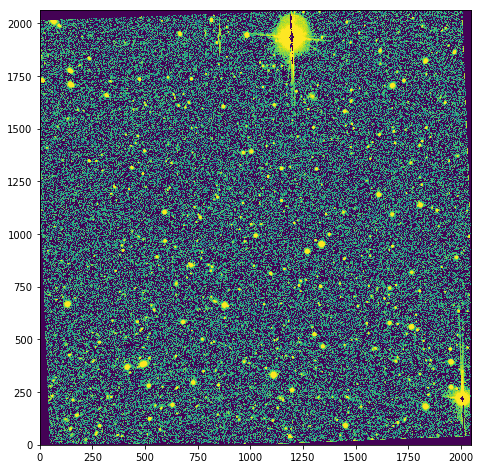

In [46]:
plt.figure(figsize=(8,8))
plt.imshow(raw_datacube.stack_field, norm=norm1, origin="lower", vmin=0, vmax=3)

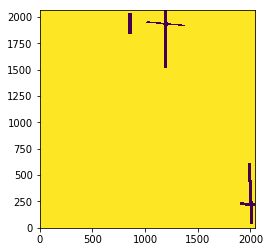

In [7]:
raw_datacube.save_weight_map(region_path="./A2390NW/A2390NW.reg", weight=0.001, save_path = './proc/A2390W/')
plt.imshow(raw_datacube.weight_map)

In [47]:
raw_datacube.save_fits(save_path = './proc/A2390W/', suffix="")

Saving background & fringe subtracted datacube and stacked field...


## 2. Extract source and spectra from datacube 

In [1]:
from pipeline import *
from utils import *

In [2]:
datacube = Read_Datacube('./proc/A2390W/A2390W_cube.fits', z0=0.228, name='A2390W', 
                         mask_edge='./proc/A2390W/Raw_stack_A2390W_mask.fits', mode="MMA")

In [3]:
src_map, segm, seg_map = datacube.ISO_source_detection(sn_thre=3, nlevels=64, contrast=0.01, box=(3,3,3),
                                                       mask_map='./proc/A2390W/weight_map_stack_A2390W.fits',
                                                       closing=True, save=True, save_path = './proc/A2390W/', suffix="")

Use the map of maximum of moving average (MMA) to detect source.
Box shape:  (3, 3, 3)
Detecting and deblending source...


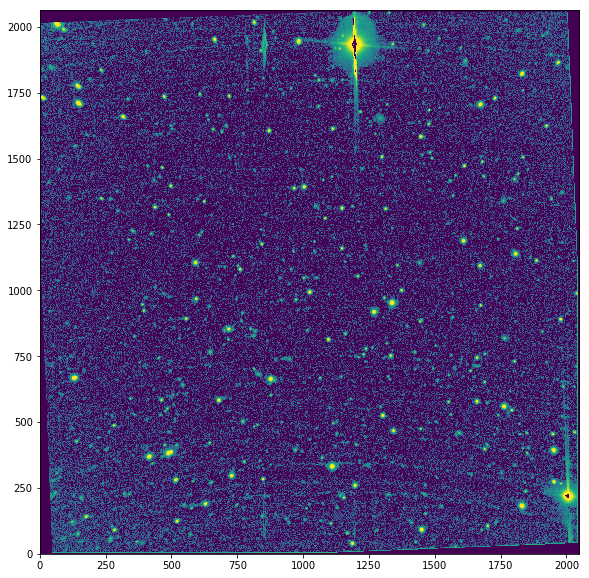

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(datacube.src_map, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=1)

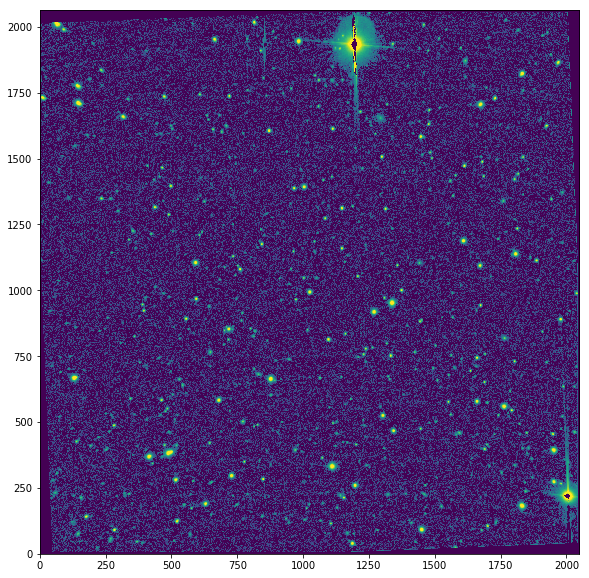

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(datacube.stack_field, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=60)

In [6]:
datacube.ISO_spec_extraction_all(seg_map)

Extract spectra... 400/4068
Extract spectra... 800/4068
Extract spectra... 1200/4068
Extract spectra... 1600/4068
Extract spectra... 2000/4068
Extract spectra... 2400/4068
Extract spectra... 2800/4068
Extract spectra... 3200/4068
Extract spectra... 3600/4068
Extract spectra... 4000/4068


In [7]:
datacube.fit_continuum_all(model='GP', plot=False, save_path='./A2390NW/fig_iso/fit_cont_MMA/')

Fit continuum with GP. No edge_ratio is given. Use estimate = 0.01
Fit spectra continuum ... 200/4068
Fit spectra continuum ... 400/4068
Fit spectra continuum ... 600/4068
Fit spectra continuum ... 800/4068
Fit spectra continuum ... 1000/4068
Fit spectra continuum ... 1200/4068
Fit spectra continuum ... 1400/4068
Fit spectra continuum ... 1600/4068
Fit spectra continuum ... 1800/4068
Fit spectra continuum ... 2000/4068
Fit spectra continuum ... 2200/4068
Fit spectra continuum ... 2400/4068
Fit spectra continuum ... 2600/4068
Fit spectra continuum ... 2800/4068
Fit spectra continuum ... 3000/4068
Fit spectra continuum ... 3200/4068
Fit spectra continuum ... 3400/4068
Fit spectra continuum ... 3600/4068
Fit spectra continuum ... 3800/4068
Fit spectra continuum ... 4000/4068
Skip spurious detection:  #2943 #3443 #3444 #3452 #3454 #3456 #3457 #3458 #3459 #3461 #3465 #3466 #3468 #3470 #3471 #3472 #3473 #3476 #3478 #3479 #3480 #3482 #3484 #3486 #3488 #3489 #3490 #3492 #3493 #3495 #3500 #3503

In [8]:
datacube.save_spec_fits(save_path='./proc/A2390W', suffix="_all")

## 3. Generate Templates

In [1]:
from pipeline import *
from utils import *

In [2]:
datacube = Read_Datacube('./proc/A2390W/A2390W_cube.fits', 
                         name='A2390W', z0=0.228, mode="MMA",
                         table='./proc/A2390W/A2390W_MMA.dat', 
                         seg_map='./proc/A2390W/A2390W_segm_MMA.fits')

In [3]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2, 
                           temp_type="OII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.), 
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8),
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='gauss')

Template: OII_gauss  Total Number: 10
Template: Hb-OIII_gauss  Total Number: 80
Template: Ha-NII_gauss  Total Number: 400


In [4]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2,
                           temp_type="OII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.),
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8), 
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='box')

Template: OII_box  Total Number: 1
Template: Hb-OIII_box  Total Number: 8
Template: Ha-NII_box  Total Number: 40


In [5]:
for mod in ['gauss','box']:
    for typ in ["Ha-NII", "Hb-OIII", "OII"]:
        datacube.Save_Template(save_path='./proc/template/', temp_type=typ, temp_model=mod)

Save A2390W templates for Ha-NII_gauss as Template-A2390W_Ha-NII_gauss.fits
Save A2390W templates for Hb-OIII_gauss as Template-A2390W_Hb-OIII_gauss.fits
Save A2390W templates for OII_gauss as Template-A2390W_OII_gauss.fits
Save A2390W templates for Ha-NII_box as Template-A2390W_Ha-NII_box.fits
Save A2390W templates for Hb-OIII_box as Template-A2390W_Hb-OIII_box.fits
Save A2390W templates for OII_box as Template-A2390W_OII_box.fits


## 4. Cross-correlation

In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
datacube = Read_Datacube('./proc/A2390W/A2390W_cube.fits', 
                         name='A2390W', z0=0.228, mode="MMA",
                         table='./proc/A2390W/A2390W_MMA.dat', 
                         seg_map='./proc/A2390W/A2390W_segm_MMA.fits')

datacube.read_spec('./proc/A2390W/A2390W-spec-MMA_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2390W')

Read Emission Line Template:
['./proc/template/Template-A2390W_Ha-NII_gauss.fits',
 './proc/template/Template-A2390W_Hb-OIII_gauss.fits',
 './proc/template/Template-A2390W_OII_gauss.fits',
 './proc/template/Template-A2390W_Ha-NII_box.fits',
 './proc/template/Template-A2390W_Hb-OIII_box.fits',
 './proc/template/Template-A2390W_OII_box.fits']


Detection #177  z: 0.222  sigma: 5.677  Peak R: 2.189  Detction S/N: 11.677 Peak S/N: 8.404


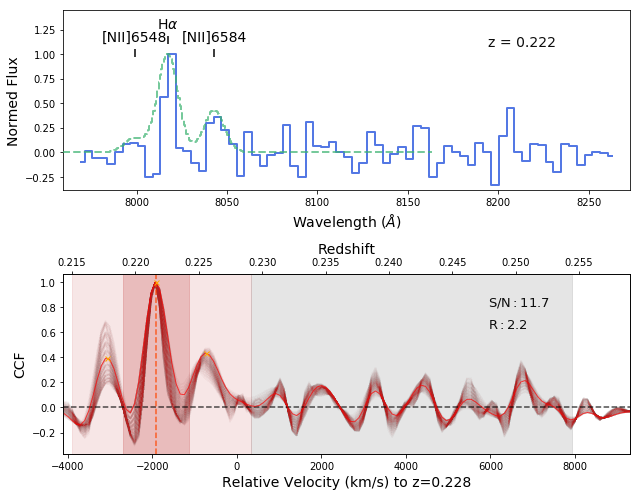

In [3]:
result = datacube.cross_correlation(177, temp_type="Ha-NII", edge=20, temp_model="gauss")

In [4]:
datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="OII", temp_model="gauss", edge=20, verbose=False)

Do cross-correlation using Ha-NII_gauss model templates...
Do cross-correlation using Hb-OIII_gauss model templates...
Do cross-correlation using OII_gauss model templates...


In [5]:
datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="box", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="box", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="OII", temp_model="box", edge=20, verbose=False)

Do cross-correlation using Ha-NII_box model templates...
Do cross-correlation using Hb-OIII_box model templates...
Do cross-correlation using OII_box model templates...


In [6]:
datacube.save_cc_result(save_path='./proc/A2390W/')

Save cross-correlation results for A2390W as : ./proc/A2390W/A2390W-cc.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss', 'Ha-NII_box', 'Hb-OIII_box', 'OII_box']


## 5. Select Candidate

In [7]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
datacube = Read_Datacube('./proc/A2390W/A2390W_cube.fits', 
                         name='A2390W', z0=0.228, mode="MMA",
                         table='./proc/A2390W/A2390W_MMA.dat', 
                         seg_map='./proc/A2390W/A2390W_segm_MMA.fits',
                         mask_edge='./proc/A2390W/Raw_stack_A2390W_mask.fits')

datacube.deep_frame =  fits.open('./proc/A2390W/A2390W_DF.fits')[0].data
datacube.src_map = fits.open('./proc/A2390W/A2390W_MMA.fits')[0].data
datacube.read_spec('./proc/A2390W/A2390W-spec-MMA_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2390W')
datacube.read_cc_result('./proc/A2390W/A2390W-cc.pkl')

Read Emission Line Template:
['./proc/template/Template-A2390W_Ha-NII_gauss.fits',
 './proc/template/Template-A2390W_Hb-OIII_gauss.fits',
 './proc/template/Template-A2390W_OII_gauss.fits',
 './proc/template/Template-A2390W_Ha-NII_box.fits',
 './proc/template/Template-A2390W_Hb-OIII_box.fits',
 './proc/template/Template-A2390W_OII_box.fits']
Read cross-correlation results for A2390W from : ./proc/A2390W/A2390W-cc.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss', 'Ha-NII_box', 'Hb-OIII_box', 'OII_box']


In [9]:
SNR_best_Ha_gauss = datacube.get_CC_result_best('SNR', 'Ha-NII_gauss')
SNR_best_OIII_gauss = datacube.get_CC_result_best('SNR', 'Hb-OIII_gauss')
SNR_best_OII_gauss = datacube.get_CC_result_best('SNR', 'OII_gauss')

SNR_best_Ha_box = datacube.get_CC_result_best('SNR', 'Ha-NII_box')
SNR_best_OII_box = datacube.get_CC_result_best('SNR', 'OII_box')

z_best_OIII_gauss = datacube.get_CC_result_best('z_best', 'Hb-OIII_gauss')
flag_e_Ha_gauss = datacube.get_CC_result_best('flag_e', 'Ha-NII_gauss')


### Match with SDSS stars

In [10]:
cat_match = datacube.match_sdss_star(sep=3*u.arcsec, search_radius=7*u.arcmin, band='rmag')

c_match_star = SkyCoord(ra=cat_match["RA_ICRS"], dec=cat_match["DE_ICRS"])
star_match_pos = np.array(c_match_star.to_pixel(datacube.wcs, origin=0)).T

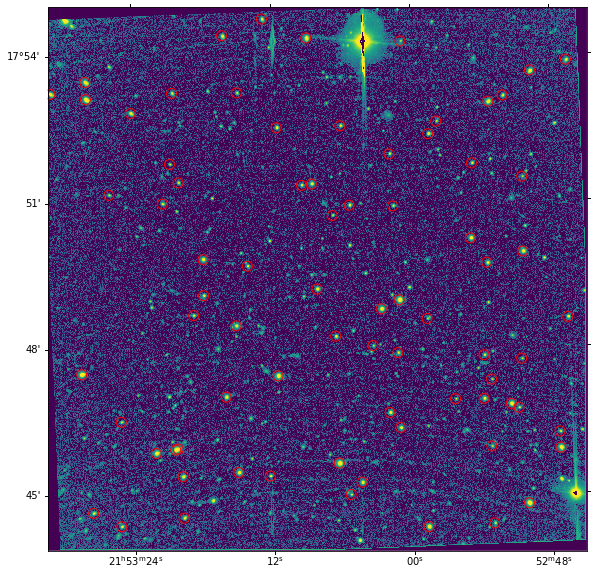

In [11]:
plt.figure(figsize=(10,10))
ax = plt.subplot(projection=datacube.wcs)
plt.scatter(star_match_pos[:,0], star_match_pos[:,1], s=100, facecolor="none", edgecolor="r")
plt.imshow(datacube.src_map, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=1)

### Measure distance

In [32]:
dist_to_edge = measure_dist_to_edge(datacube.table, datacube.mask_edge, pad=200)

### Measure EW

(-15.009104577995473, 5.9420354066472)

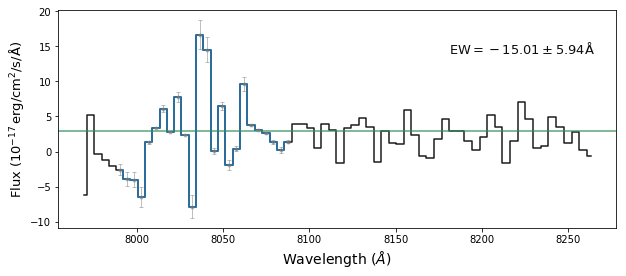

In [13]:
datacube.estimate_EW(24, MC_err=True, sigma=5)

(279.71114369465704, 81.83794986126364)

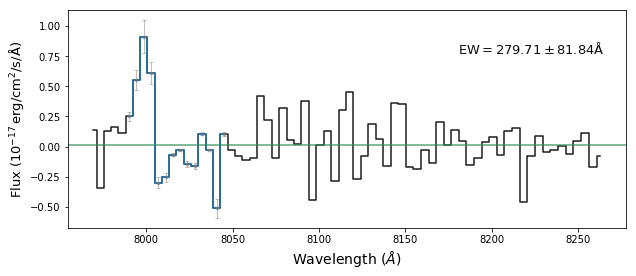

In [39]:
datacube.estimate_EW(25, MC_err=True, sigma=5)

In [28]:
datacube.estimate_EW_all(MC_err=True, sigma=5)

Measure EW... 400/4068
Measure EW... 800/4068
Measure EW... 1200/4068
Measure EW... 1600/4068
Measure EW... 2000/4068
Measure EW... 2400/4068
Measure EW... 2800/4068
Measure EW... 3200/4068
Measure EW... 3600/4068
Measure EW... 4000/4068


In [40]:
good_channel = (np.argmax(datacube.obj_specs_opt, axis=1)>7)

### Conditions

In [44]:
EW_cond = (datacube.EWs > datacube.EW_stds) & (datacube.EWs > 5)
edge_cond = dist_to_edge > 5

SNR_min_gauss = np.min([SNR_best_Ha_gauss, SNR_best_OIII_gauss, SNR_best_OII_gauss], axis=0)
SNR_min_cond = SNR_min_gauss > 3

SNR_cond_A = (SNR_best_Ha_gauss > 8) & (SNR_best_OII_gauss>3)
SNR_cond_B = (SNR_best_Ha_gauss > 5) & (SNR_best_Ha_gauss <= 8) & (SNR_best_OII_gauss>5)

zmin_OIII = datacube.wavl.min()/4959-1
# SN OIII > 5, SN OIII > SN Ha, SN OIII > SN OII 
SNR_cond_C = (SNR_best_OIII_gauss > np.max([5*np.ones_like(datacube.obj_nums), SNR_best_Ha_gauss], axis=0)) \
            & SNR_min_cond & (z_best_OIII_gauss>zmin_OIII)

num_c = datacube.obj_nums[EW_cond & SNR_cond_B & edge_cond & good_channel]

# remove stars and possible artifacts
num_c = np.setdiff1d(num_c, cat_match["NUMBER"])
num_c = np.setdiff1d(num_c, datacube.num_spurious)
print(num_c)
print(len(num_c))

[ 108  181  199  232  340  359  387  434  437  468  485  517  542  543
  565  579  617  631  658  679  680  724  730  755  791  823  827  837
  848  850  872  881  959  965  974  990 1011 1044 1055 1074 1118 1132
 1148 1159 1232 1250 1258 1260 1265 1278 1300 1309 1419 1423 1466 1471
 1501 1516 1575 1631 1654 1697 1713 1804 1936 1963 1987 2068 2149 2199
 2206 2228 2270 2356 2376 2394 2395 2399 2426 2427 2440 2455 2457 2469
 2473 2502 2559 2561 2579 2588 2590 2617 2656 2747 2749 2750 2782 2804
 2821 2832 2836 2841 2844 2864 2897 2906 2908 2960 2977 2996 3031 3041
 3054 3068 3085 3090 3103 3136 3155 3188 3190 3269 3273 3283 3295 3300
 3317 3332 3349 3368 3370 3373 3388 3399 3419 3428 3433 3537 3622 3662
 3666 3675 3722 3724 3727 3736 3749 3800 3858 3873 3875 3883 3884 3894
 3899 3900 3901 3908 3927 3934 3935 3996 4009 4014 4039 4060 4061]
167


In [45]:
v = 'B'
save_path = './A2390NW/fig_iso/candidate/%s'%v
check_save_path(save_path, clear=True)
for k, num in enumerate(num_c):
    if np.mod(k+1, 40)==0: print("Plot: %d/%d"%(k+1, len(num_c)))
    datacube.plot_candidate(num, temp_type="Ha-NII", temp_model="gauss")
    plt.savefig(os.path.join(save_path, "#%d.png"%num),dpi=75)
    plt.title("Sample %s"%v)
    plt.close()

./A2390NW/fig_iso/candidate/B exists. Remove all the content.
Plot: 40/167
Plot: 80/167
Plot: 120/167
Plot: 160/167


Detection #1876  z: 0.245  sigma: 3.018  Peak R: 6.850  Detction S/N: 9.608 Peak S/N: 9.968


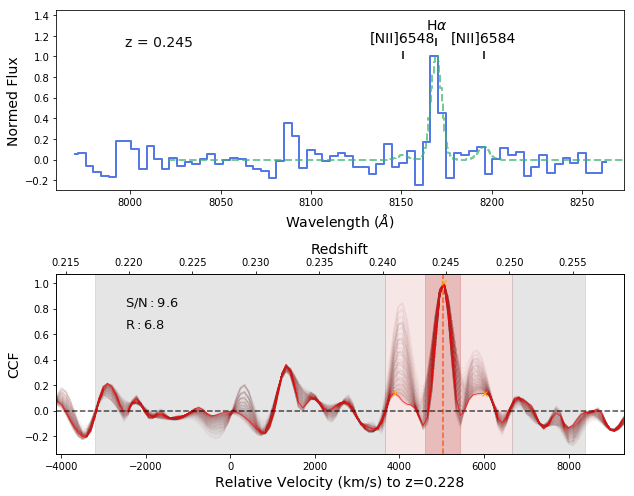

In [27]:
result = datacube.cross_correlation(1876, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

Detection #1055  z: 0.628  sigma: 3.418  Peak R: 1.000  Detction S/N: 5.468 Peak S/N: 5.468


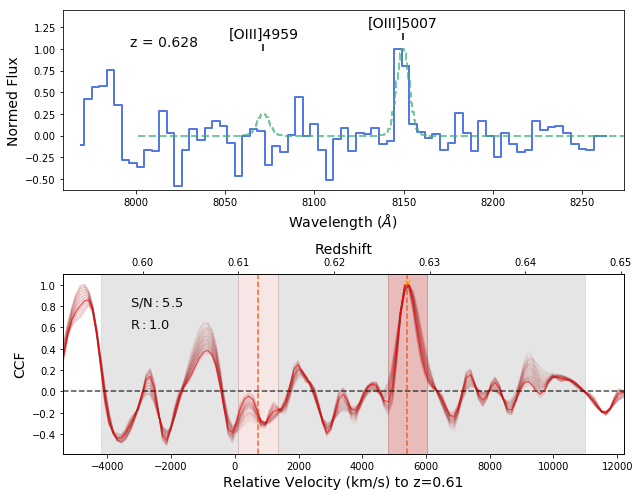

In [34]:
result = datacube.cross_correlation(1055, temp_type="Hb-OIII", edge=20, const_window=False, temp_model="gauss")

Detection #3813  z: 0.636  sigma: 3.418  Peak R: 2.612  Detction S/N: 10.292 Peak S/N: 10.292


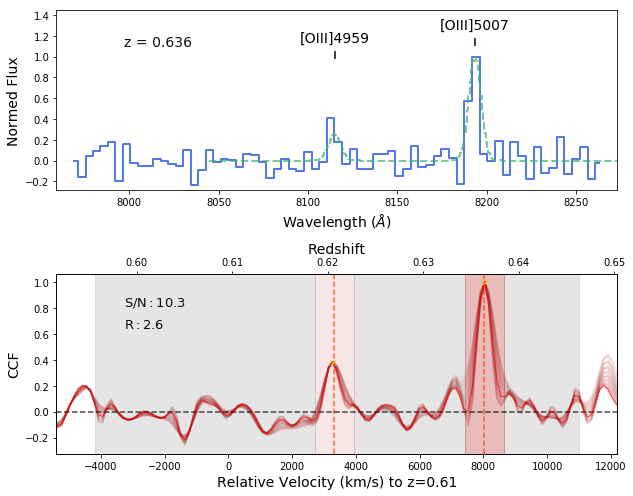

In [18]:
result = datacube.cross_correlation(3813, temp_type="Hb-OIII", edge=20, const_window=False, temp_model="gauss")

## 6. Measure Centroid

In [2]:
from pipeline import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
datacube = Read_Datacube('./proc/A2390W/A2390W_cube.fits', 
                         name='A2390W', z0=0.228, mode="MMA",
                         table='./proc/A2390W/A2390W_MMA.dat', 
                         seg_map='./proc/A2390W/A2390W_segm_MMA.fits',
                         deep_frame='./proc/A2390W/A2390W_DF.fits',
                         mask_edge='./proc/A2390W/Raw_stack_A2390W_mask.fits')
datacube.get_wcs()
datacube.src_map = fits.open('./proc/A2390W/A2390W_MMA.fits')[0].data
datacube.read_spec('./proc/A2390W/A2390W-spec-MMA_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2390W')
datacube.read_cc_result('./proc/A2390W/A2390W-cc.pkl')

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Read Emission Line T

In [4]:
el_v = glob.glob("./A2390NW/fig_iso/candidate/V/#*.png")
Num_v_all = np.sort(np.array([re.compile(r'\d+').findall(el)[-1] for el in el_v]).astype("int"))
Num_non = [2561]
Num_v = np.setdiff1d(Num_v_all, Num_non)
Num_v

array([  24,   69,  108,  129,  177,  195,  235,  359,  401,  517,  595,
        689,  791,  837,  850,  851,  872,  881,  978, 1031, 1055, 1074,
       1263, 1273, 1345, 1419, 1466, 1713, 1717, 1730, 1752, 1775, 1816,
       1908, 1940, 1987, 2010, 2127, 2150, 2245, 2278, 2346, 2459, 2561,
       2562, 2593, 2715, 2793, 2818, 2821, 2897, 2908, 3301, 3388, 3537,
       3597, 3705, 3858, 3876, 3908, 3934, 3942])

In [5]:
datacube.assign_BCG_coordinate((328.40351201,17.69544013))
X_BCG, Y_BCG = datacube.wcs.all_world2pix(datacube.coord_BCG.ra, datacube.coord_BCG.dec, 0)
datacube.pos_BCG = (X_BCG, Y_BCG)

BCG coordinate:  21h53m36.8429s +17d41m43.5845s


Error of light-wighted centroid: $\sigma_{\left<x\right>} = \Sigma_j \frac{\sigma^2_{I_j} \cdot (x_j-\left<x\right>)^2}{\Sigma_i I_i^2}$

http://ugastro.berkeley.edu/infrared09/PDF-2009/centroid-error.pdf

stddev emission: 0.021 / continuum: 0.004
Centroid EM: (1461.46+/-0.01, 152.65+/-0.01)
Centroid CON: (1461.14+/-0.01, 152.89+/-0.00)


{'diff_angle': 54.785547381069875,
 'cen_offset': 0.3998591464821041,
 'diff_angle_std': 1.2798091465547232,
 'cen_offset_std': 0.009255219316542503,
 'pa': 53.00761429140357,
 'clus_cen_angle': 107.79316167247345,
 'dist_clus_cen': 1787.067085808245}

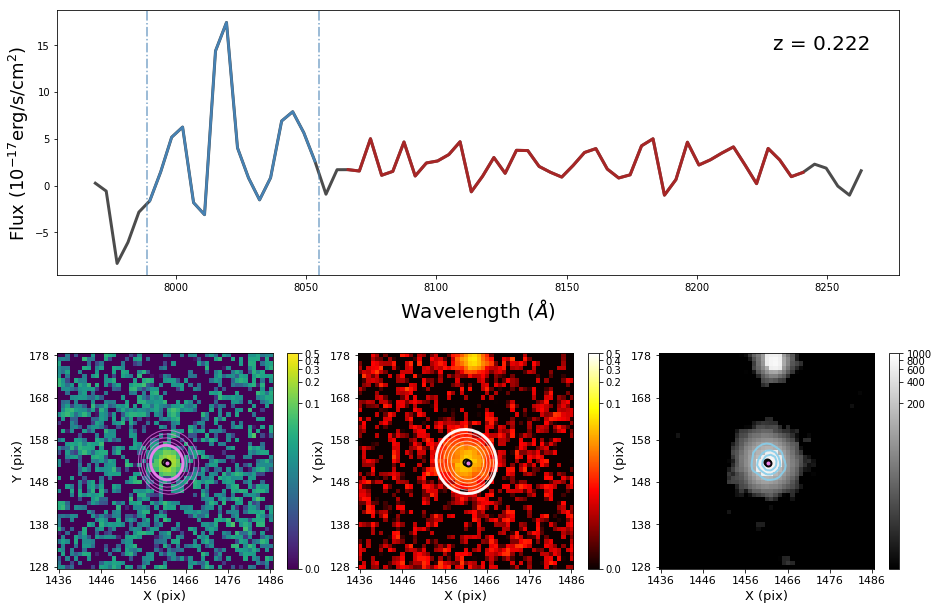

In [52]:
num = 195
datacube.centroid_analysis(num, centroid_type="APER", smooth=False)

stddev emission: 0.023 / continuum: 0.004
Centroid EM: (196.17+/-0.07, 143.38+/-0.11)
Centroid CON: (194.00+/-0.02, 142.01+/-0.05)


{'diff_angle': 19.23210281247421,
 'cen_offset': 2.5665849413971644,
 'diff_angle_std': 2.4429317159416963,
 'cen_offset_std': 0.09030900979722352,
 'pa': 122.29839642623139,
 'clus_cen_angle': 141.5304992387056,
 'dist_clus_cen': 713.1042365854337}

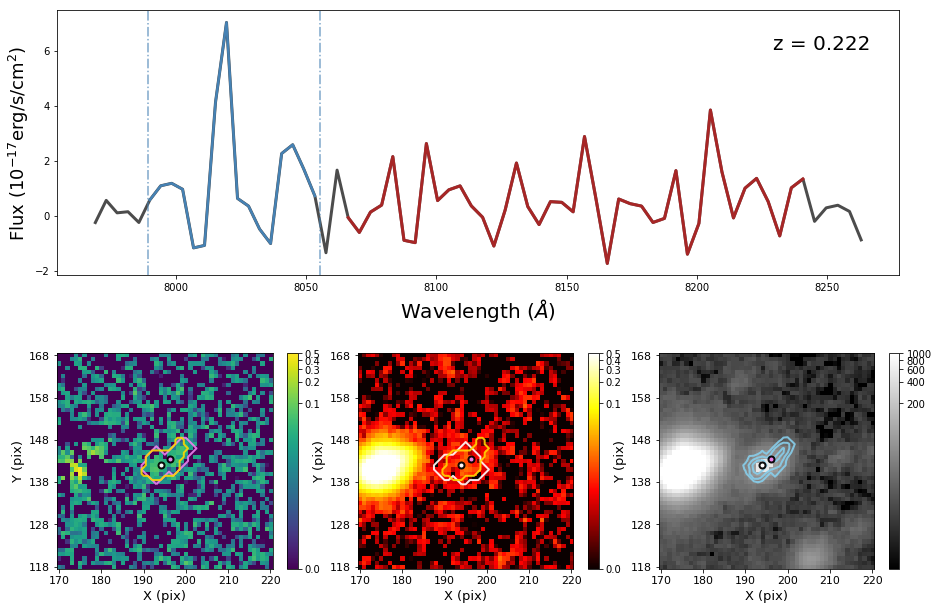

In [48]:
num = 177
datacube.centroid_analysis(num, centroid_type="ISO-D", smooth=False)

stddev emission: 0.021 / continuum: 0.004
Centroid EM: (1461.53+/-0.10, 152.78+/-0.10)
Centroid CON: (1460.41+/-0.07, 153.05+/-0.07)


{'diff_angle': 31.000953313267985,
 'cen_offset': 1.1469650116191827,
 'diff_angle_std': 6.123460713758983,
 'cen_offset_std': 0.12258137071165132,
 'pa': 76.79220835920546,
 'clus_cen_angle': 107.79316167247345,
 'dist_clus_cen': 1787.067085808245}

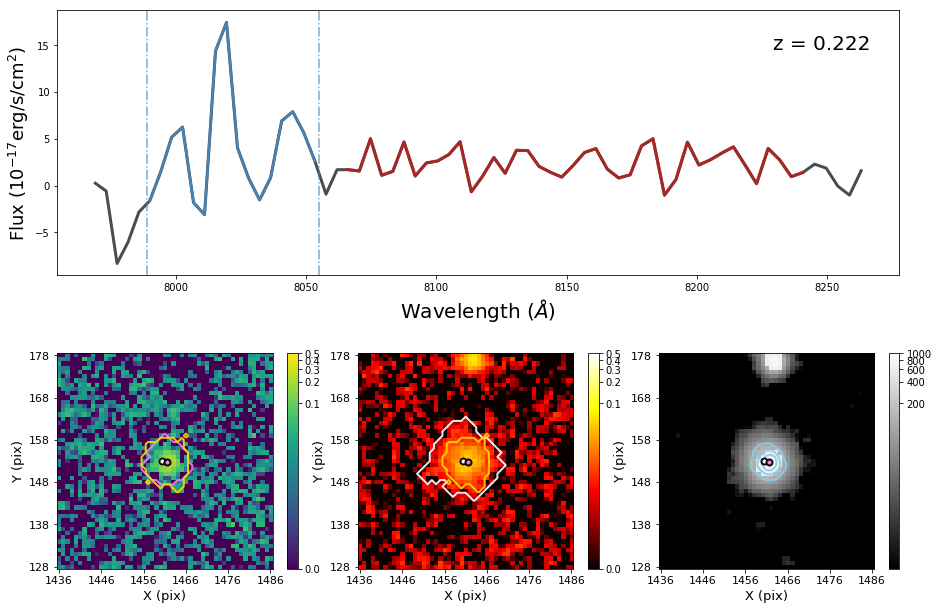

In [56]:
num = 195
datacube.centroid_analysis(num, centroid_type="ISO-D", morph_cen=True, smooth=False)

In [6]:
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="APER")


Candidate: #24
stddev emission: 0.017 / continuum: 0.005
Centroid EM: (1423.75+/-0.01, 44.82+/-0.01)
Centroid CON: (1423.89+/-0.01, 45.18+/-0.01)
Angle: 126.55 +/- 2.78
Offset: 0.38 +/- 0.02

Candidate: #69
stddev emission: 0.021 / continuum: 0.004
Centroid EM: (1165.24+/-0.01, 78.84+/-0.01)
Centroid CON: (1165.40+/-0.00, 78.69+/-0.00)
Angle: 118.14 +/- 2.83
Offset: 0.23 +/- 0.01

Candidate: #108
stddev emission: 0.020 / continuum: 0.006
Centroid EM: (272.87+/-0.02, 104.81+/-0.02)
Centroid CON: (272.03+/-0.05, 105.86+/-0.05)
Angle: 96.33 +/- 2.28
Offset: 1.35 +/- 0.05

Candidate: #129
stddev emission: 0.019 / continuum: 0.006
Centroid EM: (121.26+/-0.01, 122.12+/-0.01)
Centroid CON: (123.27+/-0.01, 121.07+/-0.02)
Angle: 96.97 +/- 0.54
Offset: 2.26 +/- 0.02

Candidate: #177
stddev emission: 0.022 / continuum: 0.005
Centroid EM: (195.04+/-0.09, 142.67+/-0.12)
Centroid CON: (194.44+/-0.02, 142.19+/-0.03)
Angle: 12.33 +/- 8.50
Offset: 0.77 +/- 0.11

Candidate: #195
stddev emission: 0.020 

Centroid EM: (318.95+/-0.04, 229.46+/-0.04)
Centroid CON: (319.89+/-0.01, 230.30+/-0.01)
Angle: 173.24 +/- 1.95
Offset: 1.27 +/- 0.04

Candidate: #3705
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (874.60+/-0.01, 602.01+/-0.01)
Centroid CON: (875.36+/-0.00, 602.66+/-0.00)
Angle: 178.66 +/- 0.58
Offset: 1.00 +/- 0.01

Candidate: #3858
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (922.58+/-0.07, 1116.77+/-0.03)
Centroid CON: (922.90+/-0.05, 1116.33+/-0.02)
Angle: 73.18 +/- 7.47
Offset: 0.55 +/- 0.06

Candidate: #3876
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1054.17+/-0.05, 1311.54+/-0.02)
Centroid CON: (1054.13+/-0.07, 1314.04+/-0.05)
Angle: 141.75 +/- 1.95
Offset: 2.50 +/- 0.05

Candidate: #3908
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (452.39+/-0.84, 1593.70+/-1.24)
Centroid CON: (451.40+/-0.12, 1592.93+/-0.16)
Angle: 32.64 +/- 50.70
Offset: 1.26 +/- 1.02

Candidate: #3934
stddev emission: 0.014 / continuum: 0.005
Centroid EM: (1451.76+/

In [7]:
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", morph_cen=False)


Candidate: #24
stddev emission: 0.017 / continuum: 0.005
Centroid EM: (1423.67+/-0.01, 44.86+/-0.01)
Centroid CON: (1423.78+/-0.01, 44.91+/-0.01)
Angle: 173.10 +/- 6.89
Offset: 0.13 +/- 0.02

Candidate: #69
stddev emission: 0.021 / continuum: 0.004
Centroid EM: (1165.46+/-0.02, 79.18+/-0.02)
Centroid CON: (1165.50+/-0.00, 78.55+/-0.00)
Angle: 75.26 +/- 1.50
Offset: 0.64 +/- 0.02

Candidate: #108
stddev emission: 0.020 / continuum: 0.006
Centroid EM: (273.10+/-0.02, 104.75+/-0.03)
Centroid CON: (272.98+/-0.05, 105.53+/-0.02)
Angle: 126.28 +/- 3.71
Offset: 0.80 +/- 0.04

Candidate: #129
stddev emission: 0.019 / continuum: 0.006
Centroid EM: (121.42+/-0.01, 122.07+/-0.01)
Centroid CON: (124.68+/-0.04, 118.77+/-0.04)
Angle: 79.32 +/- 0.54
Offset: 4.63 +/- 0.04

Candidate: #177
stddev emission: 0.022 / continuum: 0.005
Centroid EM: (193.37+/-0.05, 141.52+/-0.09)
Centroid CON: (193.74+/-0.02, 141.87+/-0.04)
Angle: 170.70 +/- 8.84
Offset: 0.51 +/- 0.07

Candidate: #195
stddev emission: 0.020

Centroid EM: (1820.02+/-0.02, 454.69+/-0.04)
Centroid CON: (1819.79+/-0.01, 454.37+/-0.01)
Angle: 31.68 +/- 3.83
Offset: 0.39 +/- 0.03

Candidate: #850
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (1909.79+/-0.09, 459.64+/-0.08)
Centroid CON: (1908.99+/-0.05, 458.70+/-0.07)
Angle: 27.98 +/- 4.96
Offset: 1.23 +/- 0.11

Candidate: #851
stddev emission: 0.021 / continuum: 0.004
Centroid EM: (2027.14+/-0.00, 462.40+/-0.00)
Centroid CON: (2027.07+/-0.00, 461.97+/-0.00)
Angle: 60.01 +/- 0.47
Offset: 0.44 +/- 0.00

Candidate: #872
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1733.32+/-0.03, 474.62+/-0.03)
Centroid CON: (1732.56+/-0.05, 474.20+/-0.04)
Angle: 5.02 +/- 3.51
Offset: 0.87 +/- 0.06

Candidate: #881
stddev emission: 0.021 / continuum: 0.003

Candidate: #978
stddev emission: 0.017 / continuum: 0.005
Centroid EM: (358.70+/-0.02, 529.54+/-0.02)
Centroid CON: (357.78+/-0.02, 529.27+/-0.02)
Angle: 40.92 +/- 1.83
Offset: 0.96 +/- 0.02

Candidate: #1031
stddev emission

stddev emission: 0.019 / continuum: 0.003

Candidate: #1717
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (913.94+/-0.03, 963.36+/-0.03)
Centroid CON: (914.98+/-0.04, 963.67+/-0.02)
Angle: 146.86 +/- 1.90
Offset: 1.09 +/- 0.05

Candidate: #1730
stddev emission: 0.019 / continuum: 0.003

Candidate: #1752
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1095.24+/-0.03, 984.71+/-0.04)
Centroid CON: (1096.00+/-0.06, 985.81+/-0.04)
Angle: 170.19 +/- 2.94
Offset: 1.33 +/- 0.06

Candidate: #1775
stddev emission: 0.015 / continuum: 0.005

Candidate: #1816
stddev emission: 0.021 / continuum: 0.004

Candidate: #1908


stddev emission: 0.015 / continuum: 0.004

Candidate: #1940
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (2023.33+/-0.02, 1111.22+/-0.02)
Centroid CON: (2023.37+/-0.01, 1111.32+/-0.01)
Angle: 145.08 +/- 14.33
Offset: 0.11 +/- 0.03

Candidate: #1987
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1040.15+/-0.05, 1150.09+/-0.03)
Centroid CON: (1041.40+/-0.02, 1146.81+/-0.01)
Angle: 60.75 +/- 0.90
Offset: 3.51 +/- 0.03

Candidate: #2010
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (993.73+/-0.04, 1160.44+/-0.06)
Centroid CON: (993.37+/-0.11, 1161.44+/-0.13)
Angle: 121.64 +/- 6.44
Offset: 1.06 +/- 0.14

Candidate: #2127
stddev emission: 0.023 / continuum: 0.004

Candidate: #2150
stddev emission: 0.015 / continuum: 0.006
Centroid EM: (1207.69+/-0.04, 1259.79+/-0.04)
Centroid CON: (1208.97+/-0.03, 1260.01+/-0.03)
Angle: 141.27 +/- 2.31
Offset: 1.30 +/- 0.05

Candidate: #2245
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (623.00+/-0.00, 1337.25+/-0.00)
Cen

stddev emission: 0.026 / continuum: 0.003

Candidate: #2561
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (765.35+/-0.02, 1516.21+/-0.06)
Centroid CON: (766.33+/-0.05, 1515.05+/-0.03)
Angle: 68.10 +/- 2.18
Offset: 1.51 +/- 0.06

Candidate: #2562
stddev emission: 0.019 / continuum: 0.004

Candidate: #2593
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (132.57+/-0.02, 1549.26+/-0.02)
Centroid CON: (132.06+/-0.01, 1547.73+/-0.01)
Angle: 7.28 +/- 0.92
Offset: 1.61 +/- 0.03

Candidate: #2715
stddev emission: 0.014 / continuum: 0.004

Candidate: #2793
stddev emission: 0.023 / continuum: 0.003

Candidate: #2818
stddev emission: 0.015 / continuum: 0.005

Candidate: #2821
stddev emission: 0.017 / continuum: 0.004

Candidate: #2897
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1831.71+/-0.02, 1758.93+/-0.01)
Centroid CON: (1831.59+/-0.01, 1758.22+/-0.01)
Angle: 34.05 +/- 1.50
Offset: 0.72 +/- 0.02

Candidate: #2908
stddev emission: 0.015 / continuum: 0.005
Centroid EM:


Candidate: #3537
stddev emission: 0.017 / continuum: 0.005

Candidate: #3597
stddev emission: 0.019 / continuum: 0.004
Centroid EM: (319.09+/-0.02, 228.83+/-0.04)
Centroid CON: (320.08+/-0.01, 229.86+/-0.01)
Angle: 177.52 +/- 1.45
Offset: 1.43 +/- 0.04

Candidate: #3705
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (874.57+/-0.01, 602.17+/-0.01)
Centroid CON: (875.47+/-0.00, 602.82+/-0.01)
Angle: 174.10 +/- 0.71
Offset: 1.12 +/- 0.01

Candidate: #3858
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (922.60+/-0.11, 1117.86+/-0.10)
Centroid CON: (923.03+/-0.02, 1116.52+/-0.02)
Angle: 55.40 +/- 4.54
Offset: 1.41 +/- 0.11

Candidate: #3876
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1054.32+/-0.07, 1311.59+/-0.04)
Centroid CON: (1053.90+/-0.08, 1314.22+/-0.05)
Angle: 133.64 +/- 2.25
Offset: 2.67 +/- 0.07

Candidate: #3908
stddev emission: 0.017 / continuum: 0.004

Candidate: #3934
stddev emission: 0.014 / continuum: 0.005

Candidate: #3942
stddev emission: 0.01

In [8]:
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", morph_cen=True)


Candidate: #24
stddev emission: 0.017 / continuum: 0.005
Centroid EM: (1423.73+/-0.09, 45.07+/-0.09)
Centroid CON: (1423.67+/-0.08, 44.53+/-0.08)
Angle: 68.63 +/- 12.63
Offset: 0.54 +/- 0.12

Candidate: #69
stddev emission: 0.021 / continuum: 0.004
Centroid EM: (1165.66+/-0.08, 79.06+/-0.08)
Centroid CON: (1165.64+/-0.06, 78.17+/-0.06)
Angle: 70.07 +/- 6.58
Offset: 0.89 +/- 0.10

Candidate: #108
stddev emission: 0.020 / continuum: 0.006
Centroid EM: (273.17+/-0.12, 105.20+/-0.12)
Centroid CON: (273.03+/-0.13, 105.48+/-0.13)
Angle: 108.26 +/- 31.86
Offset: 0.31 +/- 0.17

Candidate: #129
stddev emission: 0.019 / continuum: 0.006
Centroid EM: (122.15+/-0.07, 121.79+/-0.07)
Centroid CON: (125.04+/-0.06, 118.61+/-0.06)
Angle: 76.87 +/- 1.24
Offset: 4.30 +/- 0.09

Candidate: #177
stddev emission: 0.022 / continuum: 0.005
Centroid EM: (193.26+/-0.18, 141.65+/-0.18)
Centroid CON: (193.71+/-0.11, 141.72+/-0.11)
Angle: 138.08 +/- 26.56
Offset: 0.46 +/- 0.21

Candidate: #195
stddev emission: 0.0

stddev emission: 0.018 / continuum: 0.005
Centroid EM: (1024.72+/-0.14, 434.34+/-0.14)
Centroid CON: (1023.63+/-0.08, 433.99+/-0.08)
Angle: 15.13 +/- 8.07
Offset: 1.14 +/- 0.16

Candidate: #837
stddev emission: 0.021 / continuum: 0.004
Centroid EM: (1819.72+/-0.10, 454.73+/-0.10)
Centroid CON: (1819.85+/-0.08, 454.02+/-0.08)
Angle: 78.02 +/- 10.33
Offset: 0.72 +/- 0.13

Candidate: #850
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (1909.74+/-0.17, 459.29+/-0.17)
Centroid CON: (1908.70+/-0.14, 458.58+/-0.14)
Angle: 12.86 +/- 10.02
Offset: 1.26 +/- 0.22

Candidate: #851
stddev emission: 0.021 / continuum: 0.004
Centroid EM: (2026.33+/-0.07, 462.84+/-0.07)
Centroid CON: (2026.90+/-0.06, 462.01+/-0.06)
Angle: 104.25 +/- 5.37
Offset: 1.01 +/- 0.09

Candidate: #872
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1733.04+/-0.12, 474.71+/-0.12)
Centroid CON: (1732.29+/-0.09, 474.46+/-0.09)
Angle: 5.04 +/- 10.86
Offset: 0.80 +/- 0.15

Candidate: #881
stddev emission: 0.021 / co


Candidate: #1263
stddev emission: 0.023 / continuum: 0.003

Candidate: #1273
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (811.40+/-0.09, 703.02+/-0.09)
Centroid CON: (811.18+/-0.08, 702.32+/-0.08)
Angle: 26.05 +/- 9.58
Offset: 0.73 +/- 0.12

Candidate: #1345
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (450.78+/-0.08, 743.76+/-0.08)
Centroid CON: (451.17+/-0.08, 744.11+/-0.08)
Angle: 164.00 +/- 12.40
Offset: 0.52 +/- 0.11

Candidate: #1419
stddev emission: 0.017 / continuum: 0.004

Candidate: #1466
stddev emission: 0.016 / continuum: 0.005

Candidate: #1713
stddev emission: 0.019 / continuum: 0.003

Candidate: #1717
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (913.65+/-0.11, 963.23+/-0.11)
Centroid CON: (915.37+/-0.09, 963.96+/-0.09)
Angle: 153.49 +/- 4.39
Offset: 1.87 +/- 0.14

Candidate: #1730
stddev emission: 0.019 / continuum: 0.003

Candidate: #1752
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1095.00+/-0.13, 984.56+/-0.13)
Centroid CON:

stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1040.03+/-0.09, 1150.17+/-0.09)
Centroid CON: (1041.58+/-0.07, 1147.21+/-0.07)
Angle: 67.55 +/- 1.99
Offset: 3.34 +/- 0.12

Candidate: #2010
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (993.50+/-0.15, 1160.50+/-0.15)
Centroid CON: (993.00+/-0.15, 1161.33+/-0.15)
Angle: 110.21 +/- 12.59
Offset: 0.97 +/- 0.21

Candidate: #2127
stddev emission: 0.023 / continuum: 0.004

Candidate: #2150
stddev emission: 0.015 / continuum: 0.006
Centroid EM: (1207.93+/-0.13, 1259.93+/-0.13)
Centroid CON: (1209.24+/-0.11, 1260.35+/-0.11)
Angle: 149.21 +/- 7.07
Offset: 1.38 +/- 0.17

Candidate: #2245
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (623.17+/-0.07, 1337.68+/-0.07)
Centroid CON: (623.31+/-0.07, 1337.55+/-0.07)
Angle: 71.58 +/- 31.02
Offset: 0.19 +/- 0.10

Candidate: #2278
stddev emission: 0.016 / continuum: 0.005

Candidate: #2346
stddev emission: 0.021 / continuum: 0.003

Candidate: #2459
stddev emission: 0.026 / continu

stddev emission: 0.019 / continuum: 0.004

Candidate: #2593
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (132.61+/-0.10, 1549.30+/-0.10)
Centroid CON: (131.97+/-0.07, 1547.55+/-0.07)
Angle: 8.68 +/- 3.93
Offset: 1.86 +/- 0.13

Candidate: #2715
stddev emission: 0.014 / continuum: 0.004

Candidate: #2793
stddev emission: 0.023 / continuum: 0.003

Candidate: #2818
stddev emission: 0.015 / continuum: 0.005

Candidate: #2821
stddev emission: 0.017 / continuum: 0.004

Candidate: #2897
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1831.45+/-0.10, 1759.05+/-0.10)
Centroid CON: (1831.05+/-0.07, 1757.80+/-0.07)
Angle: 26.12 +/- 5.26
Offset: 1.31 +/- 0.12

Candidate: #2908
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (909.79+/-0.13, 1762.79+/-0.13)
Centroid CON: (911.07+/-0.13, 1763.75+/-0.13)
Angle: 154.99 +/- 6.76
Offset: 1.60 +/- 0.19

Candidate: #3301
stddev emission: 0.030 / continuum: 0.004

Candidate: #3388
stddev emission: 0.016 / continuum: 0.007



Candidate: #3537
stddev emission: 0.017 / continuum: 0.005

Candidate: #3597
stddev emission: 0.019 / continuum: 0.004
Centroid EM: (319.35+/-0.11, 228.91+/-0.11)
Centroid CON: (319.91+/-0.08, 230.49+/-0.08)
Angle: 158.13 +/- 4.81
Offset: 1.68 +/- 0.14

Candidate: #3705
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (874.82+/-0.09, 602.82+/-0.09)
Centroid CON: (875.57+/-0.07, 602.73+/-0.07)
Angle: 131.42 +/- 8.57
Offset: 0.76 +/- 0.11

Candidate: #3858
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (922.31+/-0.16, 1118.21+/-0.16)
Centroid CON: (923.39+/-0.10, 1116.63+/-0.10)
Angle: 72.26 +/- 5.70
Offset: 1.92 +/- 0.19

Candidate: #3876
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1054.87+/-0.11, 1311.41+/-0.11)
Centroid CON: (1054.18+/-0.14, 1314.08+/-0.14)
Angle: 128.15 +/- 3.64
Offset: 2.76 +/- 0.18

Candidate: #3908
stddev emission: 0.017 / continuum: 0.004

Candidate: #3934
stddev emission: 0.014 / continuum: 0.005

Candidate: #3942
stddev emission: 0.01

In [9]:
datacube.result_centroid.keys()

dict_keys(['APER', 'ISO-D', 'ISO-Dm'])

In [11]:
datacube.save_centroid_measurement(Num_v, save_path='./proc/', ID_field='W')

Save centroid measurement as catalog:  ./proc/centroid_analysis_A2390W.txt


In [10]:
z_V =  datacube.get_CC_result_best('z_best', 'Ha-NII_gauss', Num_v)
diff_angle_aper = datacube.get_centroid_result('diff_angle', 'APER', fill_value=0)
diff_angle_std_aper = datacube.get_centroid_result('diff_angle_std', 'APER', fill_value=99)
cen_off_aper = datacube.get_centroid_result('cen_offset', 'APER', fill_value=0)
cen_off_std_aper = datacube.get_centroid_result('cen_offset_std', 'APER', fill_value=99)

In [7]:
diff_angle_iso_d = datacube.get_centroid_result('diff_angle', 'ISO-D', fill_value=0)
diff_angle_std_iso_d = datacube.get_centroid_result('diff_angle_std', 'ISO-D', fill_value=99)
cen_off_iso_d = datacube.get_centroid_result('cen_offset', 'ISO-D', fill_value=0)
cen_off_std_iso_d = datacube.get_centroid_result('cen_offset_std', 'ISO-D', fill_value=99)

diff_angle_iso_dm = datacube.get_centroid_result('diff_angle', 'ISO-Dm', fill_value=0)
cen_off_iso_dm = datacube.get_centroid_result('cen_offset', 'ISO-Dm', fill_value=0)
cen_off_std_iso_dm = datacube.get_centroid_result('cen_offset_std', 'ISO-Dm', fill_value=99)

In [28]:
def condition_1(cen_off, cen_off_std, z_V):
    return (cen_off>1) & (cen_off>3*cen_off_std) & (abs(z_V-0.228)<0.015) & (z_V>0.22)

def condition_2(cen_off, cen_off_std, z_V):
    return (cen_off>1+3*cen_off_std) & (abs(z_V-0.228)<0.015)

cond = condition_2

cond_a = cond(cen_off_aper, cen_off_std_aper, z_V)
cond_d = cond(cen_off_iso_d, cen_off_std_iso_d, z_V)
cond_dm = cond(cen_off_iso_dm, cen_off_std_iso_dm, z_V)

d_angle_a1 = diff_angle_aper[cond_a]
d_angle_d1 = diff_angle_iso_d[cond_d]
d_angle_dm1 = diff_angle_iso_dm[cond_dm]

In [29]:
num_a1 = Num_v[cond_a]
num_d1 = Num_v[cond_d]
nums1 = np.intersect1d(num_a1, num_d1)
nums1

array([ 129, 1031, 2150, 2908, 3597, 3876])

In [25]:
dA_a1 = datacube.get_centroid_result('diff_angle', 'APER', nums=nums1, fill_value=0)
dA_std_a1 = datacube.get_centroid_result('diff_angle_std', 'APER', nums=nums1, fill_value=99)
dA_d1 = datacube.get_centroid_result('diff_angle', 'ISO-D', nums=nums1, fill_value=0)
dA_std_d1 = datacube.get_centroid_result('diff_angle_std', 'ISO-D', nums=nums1, fill_value=99)
dA_dm1 = datacube.get_centroid_result('diff_angle', 'ISO-D_mo', nums=nums1, fill_value=0)
dA_std_dm1 = datacube.get_centroid_result('diff_angle_std', 'ISO-D_mo', nums=nums1, fill_value=99)

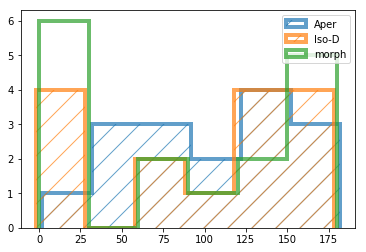

In [26]:
plt.hist(d_angle_a1+2, bins=np.linspace(0,180,7)+2,histtype="step", hatch="/", lw=4, alpha=0.7,label='Aper')
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,7)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,7),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

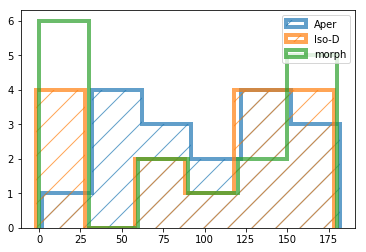

In [20]:
plt.hist(d_angle_a1+2, bins=np.linspace(0,180,7)+2,histtype="step", hatch="/", lw=4, alpha=0.7,label='Aper')
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,7)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,7),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

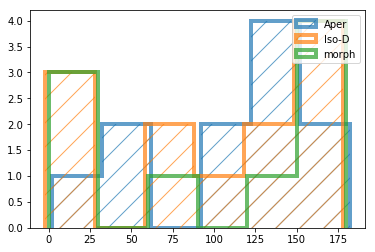

In [30]:
plt.hist(d_angle_a1+2, bins=np.linspace(0,180,7)+2,histtype="step", hatch="/", lw=4, alpha=0.7,label='Aper')
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,7)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,7),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()